In [2]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  # carma_variance computes the autcovariance function

Text(0,0.5,'Autocorrelation Function')

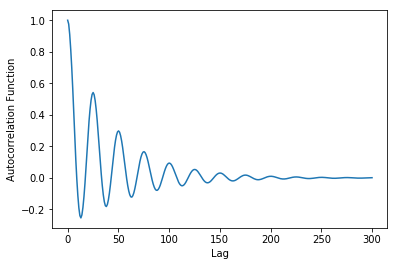

In [4]:
lag = np.linspace(0.0, 300.0, 300)
autocovar = cm.carma_variance(sigsqr, ar_roots, ma_coefs, lag)
autocorr = autocovar / autocovar[0]  # normalize by stationary variance
plt.plot(lag, autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Function')

(0, 906.15362091034694)

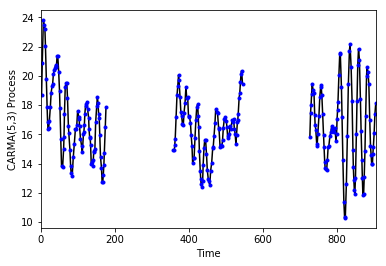

In [5]:
ny = 270
t = np.zeros(ny)
dt = np.random.uniform(1.0, 3.0, ny)
t[0:90] = np.cumsum(dt[0:90])  # season 1
t[90:2*90] = 180 + t[90-1] + np.cumsum(dt[90:2*90])  # season 2, 180 time units between seasons
t[2*90:] = 180 + t[2*90-1] + np.cumsum(dt[2*90:])  # season 3
y = mu + cm.carma_process(t, sigsqr, ar_roots, ma_coefs=ma_coefs)
for i in range(3):
    plt.plot(t[90*i:90*(i+1)], y[90*i:90*(i+1)], 'k')
    plt.plot(t[90*i:90*(i+1)], y[90*i:90*(i+1)], 'b.')
plt.xlabel('Time')
plt.ylabel('CARMA(5,3) Process')
plt.xlim(0, t.max())

In [2]:
data = np.genfromtxt('LC_R_141827.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Tiempo [dias]')
plt.ylabel('magnitud')


NameError: name 'np' is not defined

In [8]:
model = cm.CarmaModel(t, y, yerr, p=4, q=1)

In [9]:
%%capture capt
sample = model.run_mcmc(20000)

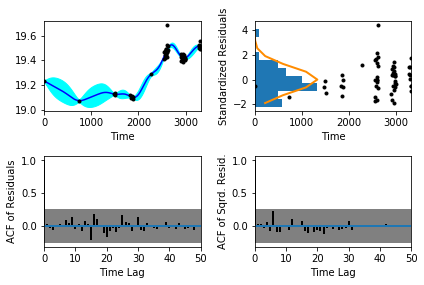

<Figure size 432x288 with 0 Axes>

In [32]:
sample.assess_fit()
plt.savefig('2')

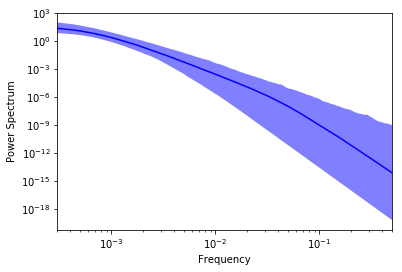

<Figure size 432x288 with 0 Axes>

In [33]:


psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)
plt.savefig('3')


In [34]:
dt = t[1:] - t[:-1]
noise_level = 2.0 * np.mean(dt) * np.mean(yerr ** 2)

In [4]:
plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.ylim(noise_level / 10.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Power Spectrum')
plt.xlabel('Frequency [1 / day]')
plt.annotate("nivel de ruido", (1.25 * plt.xlim()[0], noise_level / 1.5))

NameError: name 'plt' is not defined

Text(0.5,1,'Forecasting, Expected Value')

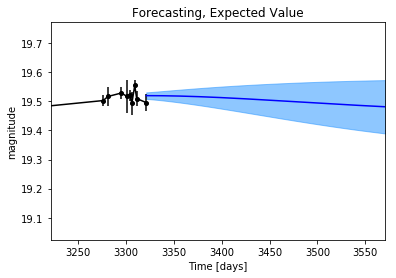

In [36]:
tpredict = t.max() + np.linspace(0.0, 250.0, 250)
ypredict, yp_var = sample.predict(tpredict)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tpredict, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tpredict, ypredict, 'b-')
plt.xlim(tpredict.min() - 100, tpredict.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.title('Forecasting, Expected Value')

Text(0.5,1,'Forecasting, Simulated Paths')

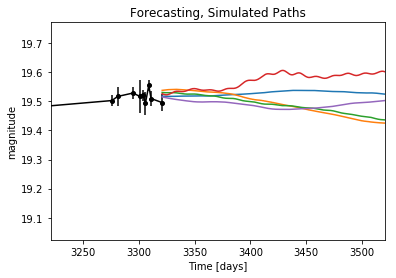

In [37]:


tpredict = t.max() + np.linspace(0.0, 200.0, 250)
npaths = 5
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
for i in range(npaths):
    ysim = sample.simulate(tpredict, bestfit='random')  # use a random draw of the CARMA parameters from its posterior
    plt.plot(tpredict, ysim)
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.xlim(tpredict.min()-100, tpredict.max())
plt.title('Forecasting, Simulated Paths')



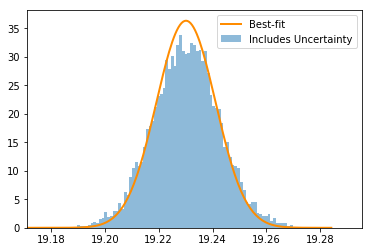

In [38]:


tpredict = 10.0
nsim = 10000
ysim = np.zeros(nsim)
for i in range(nsim):
    ysim[i] = sample.simulate(tpredict, bestfit='random')
yhat, yhvar = sample.predict(tpredict)
plt.hist(ysim, bins=100, alpha=0.5, histtype='stepfilled', normed=True, label='Includes Uncertainty')
ymin, ymax = plt.xlim()
ygrid = np.linspace(ymin, ymax, 200)
predictive_pdf = 1.0 / np.sqrt(2.0 * np.pi * yhvar) * np.exp(-0.5 * (ygrid - yhat) ** 2 / yhvar)
plt.plot(ygrid, predictive_pdf, color='DarkOrange', lw=2, label='Best-fit')
plt.xlim(ymin, ymax + 0.1 * (ymax - ymin))
plt.legend(loc='upper right')



Text(0.5,1,'Interpolation, Simulated Paths')

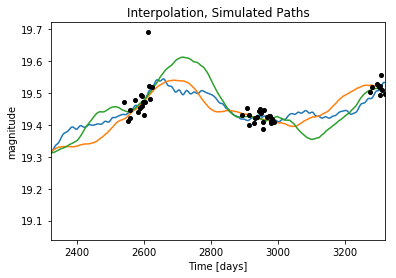

In [39]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
npaths = 3
for i in range(npaths):
    ysim = sample.simulate(tinterp, bestfit='random')
    plt.plot(tinterp, ysim)
plt.plot(t, y, 'ko', ms=4)
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolation, Simulated Paths')

In [40]:
sample.parameters

['quad_coefs',
 'logpost',
 'ar_coefs',
 'mu',
 'psd_centroid',
 'loglik',
 'psd_width',
 'var',
 'measerr_scale',
 'sigma',
 'ma_coefs',
 'ar_roots']

In [41]:


centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape



(20000, 4)

In [42]:


sample.posterior_summaries('psd_centroid')



Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 473.573060544
Median: 0.0
Standard deviation: 0.197422113049
68% credibility interval: [ 0.          0.15658912]
95% credibility interval: [ 0.          0.78375918]
99% credibility interval: [ 0.          0.94833436]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 473.573060544
Median: 0.0
Standard deviation: 0.197422113049
68% credibility interval: [ 0.          0.15658912]
95% credibility interval: [ 0.          0.78375918]
99% credibility interval: [ 0.          0.94833436]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 1191.09783471
Median: 0.0
Standard deviation: 0.0001610618985
68% credibility interval: [ 0.  

Plotting parameter summary


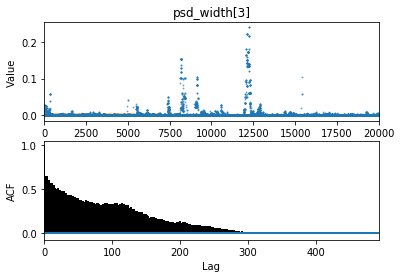

In [49]:
sample.plot_parameter('psd_width', 3, doShow=True)

Plotting 2d PDF w KDE


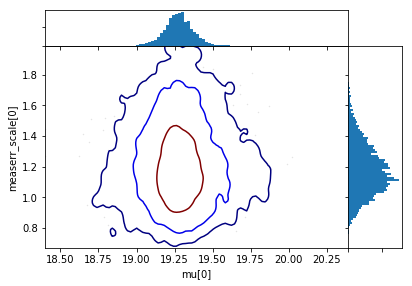

In [50]:


sample.plot_2dkde('mu', 'measerr_scale', doShow=True)



Plotting 2d PDF


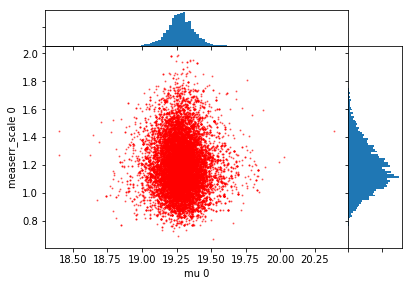

In [51]:
sample.plot_2dpdf('mu', 'measerr_scale', doShow=True)